<a href="https://colab.research.google.com/github/Zakuta/D-QRL/blob/main/working_code_QRL_theta_not_learning_cp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install equinox
# !pip install tensorcircuit
# !pip install -U qiskit
# !pip install tensorcircuit
# !pip install cirq
# !pip install openfermion
# !pip install gymnax
# !pip install brax
# !pip install distrax
# !pip install flax

In [2]:
import jax
from jax import config

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

import jax.numpy as jnp
DTYPE=jnp.float64

import chex
import numpy as np
import optax
from flax import struct
from functools import partial
import tensorcircuit as tc

# import tensorflow as tf
# from sklearn.decomposition import PCA
import equinox as eqx
import types
from jaxtyping import Array, PRNGKeyArray
from typing import Union, Sequence, List, NamedTuple, Optional, Tuple, Any, Literal, TypeVar
import jax.tree_util as jtu
import gymnax
import distrax
from gymnax.environments import environment, spaces
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

K = tc.set_backend("jax")

In [4]:
# shamelessly taken from purejaxrl: https://github.com/luchris429/purejaxrl/blob/main/purejaxrl/wrappers.py

class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env

    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)


class FlattenObservationWrapper(GymnaxWrapper):
    """Flatten the observations of the environment."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    def observation_space(self, params) -> spaces.Box:
        assert isinstance(
            self._env.observation_space(params), spaces.Box
        ), "Only Box spaces are supported for now."
        return spaces.Box(
            low=self._env.observation_space(params).low,
            high=self._env.observation_space(params).high,
            shape=(np.prod(self._env.observation_space(params).shape),),
            dtype=self._env.observation_space(params).dtype,
        )

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, state = self._env.reset(key, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state, reward, done, info


@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int


class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state=env_state,
            episode_returns=new_episode_return * (1 - done),
            episode_lengths=new_episode_length * (1 - done),
            returned_episode_returns=state.returned_episode_returns * (1 - done)
            + new_episode_return * done,
            returned_episode_lengths=state.returned_episode_lengths * (1 - done)
            + new_episode_length * done,
            timestep=state.timestep + 1,
        )
        info["returned_episode_returns"] = state.returned_episode_returns
        info["returned_episode_lengths"] = state.returned_episode_lengths
        info["timestep"] = state.timestep
        info["returned_episode"] = done
        return obs, state, reward, done, info

In [17]:
def reuploading_circuit(n_qubits, n_layers, rot_params, input_params, X):
  circuit = tc.Circuit(n_qubits)

  for l in range(n_layers):
    # variational part
    for qubit_idx in range(n_qubits):
      circuit.rx(qubit_idx, theta=rot_params[l, qubit_idx, 0])
      circuit.ry(qubit_idx, theta=rot_params[l, qubit_idx, 1])
      circuit.rz(qubit_idx, theta=rot_params[l, qubit_idx, 2])

    # entangling part
    for qubit_idx in range(n_qubits - 1):
      circuit.cnot(qubit_idx, qubit_idx + 1)
    if n_qubits != 2:
      circuit.cnot(n_qubits - 1, 0)

    # encoding part
    for qubit_idx in range(n_qubits):
      input = X[qubit_idx] * input_params[l, qubit_idx]
      # print(input)
      circuit.rx(qubit_idx, theta=input)

  # last variational part
  for qubit_idx in range(n_qubits):
    circuit.rx(qubit_idx, theta=rot_params[n_layers, qubit_idx, 0])
    circuit.ry(qubit_idx, theta=rot_params[n_layers, qubit_idx, 1])
    circuit.rz(qubit_idx, theta=rot_params[n_layers, qubit_idx, 2])

  return circuit

class QuantumActor(eqx.Module):
  theta: jax.Array = eqx.field(static=True)# trainable
  lmbd: jax.Array # trainable
  w: jax.Array # trainable
  n_qubits: int = eqx.field(static=True)
  n_layers: int = eqx.field(static=True)
  beta: float = eqx.field(static=True)
  n_actions: Sequence[int] = eqx.field(static=True)
  # key: int

  def __init__(self, n_qubits, n_layers, beta, n_actions, params: Optional, key = 42):

    key = jax.random.PRNGKey(key)
    key, _key = jax.random.split(key, num=2)

    if params is None:
      # rotation_params
      self.theta = params['thetas']
      # input encoding params
      self.lmbd = params['lmbds']
      # observable weights
      self.w = params['ws']
    else:
      self.theta = jax.random.uniform(key=key, shape=(n_layers + 1, n_qubits, 3),
                                    minval=0.0, maxval=np.pi, dtype=DTYPE)
      self.lmbd = jnp.ones(shape=(n_layers, n_qubits), dtype=DTYPE)
      self.w = jnp.array([[(-1.) ** i for i in range(n_actions)]])

    self.n_qubits = n_qubits
    self.n_layers = n_layers
    self.beta = beta
    self.n_actions = n_actions

  def quantum_policy_circuit(self, inputs):

    # this can be any PQC of the user's choice. hence, I made the decision to make a separate function within this class
    circuit = reuploading_circuit(self.n_qubits, self.n_layers, self.theta, self.lmbd, inputs)

    return K.real(circuit.expectation_ps(z=np.arange(self.n_qubits)))

  def alternating(self, inputs):
    return jnp.matmul(inputs, self.w)

  def get_params(self):
    # return {'thetas': self.theta, 'lmbds': self.lmbd, 'ws': self.w}
    return {'lmbds': self.lmbd, 'ws': self.w}


  def __call__(self, x):

    pqc = self.quantum_policy_circuit(x)
    alt = self.alternating(jnp.array([pqc], dtype=DTYPE))
    actor_mean = eqx.nn.Lambda(lambda x: x * self.beta)(alt)
    policy = distrax.Softmax(actor_mean)

    return policy

class TrainState(eqx.Module):
  model: eqx.Module
  optimizer: optax.GradientTransformation = eqx.field(static=True)
  opt_state: optax.OptState

  def __init__(self, model, optimizer, opt_state):
    self.model = model
    self.optimizer = optimizer
    self.opt_state = opt_state

  def apply_updates_to_model(self, new_params):
    # this function is specific and works for this example only. one can think of
    # generalizing it to work for updating any given attribute/params of the model.

    # model_new = eqx.tree_at(where=lambda model: model.theta, pytree=self.model, replace=new_params['thetas'])
    # model_new = eqx.tree_at(where=lambda model: model.lmbd, pytree=model_new, replace=new_params['lmbds'])
    # model_new = eqx.tree_at(where=lambda model: model.w, pytree=model_new, replace=new_params['ws'])
    model_new = eqx.tree_at(where=lambda model: model.lmbd, pytree=self.model, replace=new_params['lmbds'])
    model_new = eqx.tree_at(where=lambda model: model.w, pytree=model_new, replace=new_params['ws'])

    return model_new

  def apply_gradients(self, params, grads):
    # grads = {'thetas': grads.theta, 'lmbds': grads.lmbd, 'ws': grads.w}
    grads = {'lmbds': grads.lmbd, 'ws': grads.w}
    updates, opt_state = self.optimizer.update(grads, self.opt_state, params)
    new_params = optax.apply_updates(params, updates)
    model_new = self.apply_updates_to_model(new_params)
    # model = eqx.apply_updates(self.model, updates)
    new_train_state = self.__class__(model=model_new, optimizer=self.optimizer, opt_state=opt_state)
    return new_train_state

class Transition(NamedTuple):
  done: jnp.ndarray
  action: jnp.ndarray
  reward: jnp.ndarray
  log_prob: jnp.ndarray
  obs: jnp.ndarray
  # params: jnp.ndarray
  info: jnp.ndarray

In [20]:
@eqx.filter_jit
def train_cp(conf):
  env, env_params = gymnax.make(conf['env_name'])
  env = FlattenObservationWrapper(env)
  env = LogWrapper(env)

  n_actions = env.action_space(env_params).n

  rng = jax.random.PRNGKey(conf['rng'])
  rng, _rng = jax.random.split(rng)
  params = {'thetas': jax.random.uniform(
      key=_rng, shape=(conf['n_layers'] + 1, conf['n_qubits'], 3),
      minval=0.0, maxval=np.pi, dtype=DTYPE
      ),
            'lmbds': jnp.ones(shape=(conf['n_layers'],
                                    conf['n_qubits']), dtype=DTYPE
                              ),
            'ws': jnp.array([[(-1.) ** i for i in range(n_actions)]], dtype=DTYPE)
            }

  def train(rng):
    actor = QuantumActor(
        n_qubits=conf['n_qubits'], n_layers=conf['n_layers'],
        beta=conf['beta'], n_actions=n_actions, params=params
        )

    state_bounds = jnp.array([2.4, 2.5, 0.21, 2.5], dtype=DTYPE)

    def map_nested_fn(fn):
      '''Recursively apply `fn` to the key-value pairs of a nested dict'''
      def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
                for k, v in nested_dict.items()}
      return map_fn

    label_fn = map_nested_fn(lambda k, _: k)
    # optim = optax.multi_transform({'thetas': optax.amsgrad(conf['lr_theta']),
    #                               'lmbds': optax.amsgrad(conf['lr_lmbd']),
    #                               'ws': optax.amsgrad(conf['lr_w'])},
    #                           label_fn)
    optim = optax.multi_transform({'lmbds': optax.amsgrad(conf['lr_lmbd']),
                                  'ws': optax.amsgrad(conf['lr_w'])},
                              label_fn)

    # opt_state = optim.init(params)
    opt_state = optim.init({'lmbds': jnp.ones(shape=(conf['n_layers'],
                                    conf['n_qubits']), dtype=DTYPE
                              ),
            'ws': jnp.array([[(-1.) ** i for i in range(n_actions)]], dtype=DTYPE)
            })

    train_state = TrainState(model=actor, optimizer=optim, opt_state=opt_state)

    rng, rng_reset = jax.random.split(rng)
    #vmappable
    obs, env_state = env.reset(rng_reset, env_params)

    def update_episode(runner_state, ununsed):
      def env_step(runner_state, ununsed):

        train_state, env_state, last_obs, rng = runner_state
        rng, rng_step, rng_net = jax.random.split(rng, 3)

        actor = train_state.model
        policy = actor(last_obs.reshape(-1) / state_bounds)
        action = policy.sample(seed=rng_net)
        log_prob = policy.log_prob(action)

        #vmappable, need a resplit of rng here, so above split will be 2 and then here, split_num would be n_envs.
        obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)

        transition = Transition(
            done, action, reward, log_prob, last_obs.reshape(-1) / state_bounds, info)

        runner_state = (train_state, env_state, obs, rng)

        return runner_state, transition

      runner_state, traj_batch = jax.lax.scan(env_step, runner_state, None, conf['n_steps'])

      # obs, env_state, train_state, rng = runner_state
      train_state, env_state, last_obs, rng = runner_state

      def calculate_returns(traj_batch):
        def _compute_discounted_sum(carry, transition):
          rewards_to_go = carry
          reward = transition.reward
          rewards_to_go = reward + conf['gamma'] * rewards_to_go
          baseline = 0
          return rewards_to_go, rewards_to_go

        init_carry = jnp.zeros_like(0, dtype=DTYPE)

        _, returns = jax.lax.scan(
            _compute_discounted_sum,
            init_carry,
            traj_batch,
            reverse=True,
        )
        return returns

      returns = calculate_returns(traj_batch)

      @eqx.filter_value_and_grad
      def reinforce_update(actor, traj_batch, returns):

        policy = actor(traj_batch.obs.reshape(-1))
        log_prob = policy.log_prob(traj_batch.action)
        returns = (returns - jnp.mean(returns)) / (jnp.std(returns) + conf['eps'])
        loss = -jnp.mean(log_prob * returns) / conf['n_steps']

        return loss

      loss, grads = reinforce_update(train_state.model, traj_batch, returns)
      train_state = train_state.apply_gradients(train_state.model.get_params(), grads)

      update_state = (train_state, traj_batch, returns, rng)

      train_state = update_state[0]
      metric = traj_batch.info
      # metric = traj_batch
      rng = update_state[-1]

      # Debugging mode
      if conf['debug']:
        def callback(info):
          return_values = info['returned_episode_returns'][info['returned_episode']]
          timesteps = info['timestep'][info['returned_episode']] * conf['n_envs']
          for t in range(len(timesteps)):
            print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
        jax.debug.callback(callback, metric)

      runner_state = (train_state, env_state, last_obs, rng)

      return runner_state, metric

    rng, _rng = jax.random.split(rng)
    runner_state = (train_state, env_state, obs, _rng)
    runner_state, metric = jax.lax.scan(update_episode,
                                        runner_state,
                                        None,
                                        conf['max_episodes'] // conf['n_steps'])

    return {'runner_state': runner_state, 'metrics': metric}

  return train



In [24]:
conf = {'n_layers': 5,
        'n_qubits': 4,
        'beta': 1.0,
        'n_envs': 1,
        'total_timesteps': 125000,
        'n_steps': 10,
        'gamma': 0.99,
        'n_minibatches': 4,
        'update_epochs': 50000,
        'debug': True,
        'env_name': 'CartPole-v1',
        'lr_theta': 0.001,
        'lr_lmbd': 0.1,
        'lr_w': 0.1,
        'rng': 42,
        'eps': 1e-8,
        'max_episodes': 50000,
        'batch_size': 10}

out = train_cp(conf)(jax.random.PRNGKey(42))

<ipython-input-20-fb77488561e4>:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  params = {'thetas': jax.random.uniform(
<ipython-input-20-fb77488561e4>:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  'lmbds': jnp.ones(shape=(conf['n_layers'],
<ipython-input-20-fb77488561e4>:18: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_

global step=32, episodic return=32.0
global step=57, episodic return=25.0
global step=76, episodic return=19.0
global step=111, episodic return=35.0
global step=132, episodic return=21.0
global step=192, episodic return=60.0
global step=234, episodic return=42.0
global step=311, episodic return=77.0
global step=349, episodic return=38.0
global step=425, episodic return=76.0
global step=508, episodic return=83.0
global step=542, episodic return=34.0
global step=619, episodic return=77.0
global step=679, episodic return=60.0
global step=782, episodic return=103.0
global step=832, episodic return=50.0
global step=890, episodic return=58.0
global step=950, episodic return=60.0
global step=1047, episodic return=97.0
global step=1085, episodic return=38.0
global step=1144, episodic return=59.0
global step=1176, episodic return=32.0
global step=1259, episodic return=83.0
global step=1303, episodic return=44.0
global step=1374, episodic return=71.0
global step=1447, episodic return=73.0
global

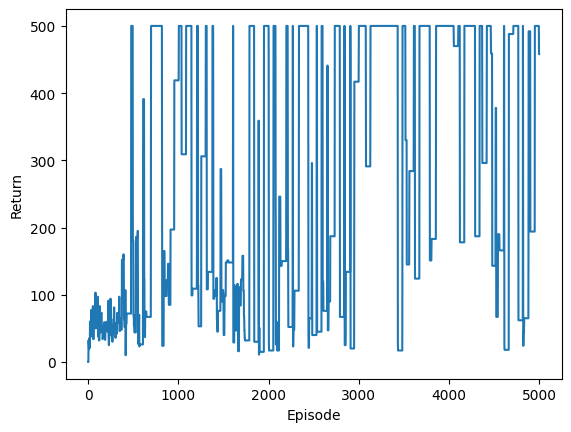

In [25]:
import matplotlib.pyplot as plt
plt.plot(out['metrics']['returned_episode_returns'].mean(-1).reshape(-1))
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

In [26]:
out['runner_state'][0].model.get_params()

{'lmbds': Array([[ -4.72193   ,   4.3991113 ,  -3.4003642 ,  13.471881  ],
        [  2.058846  ,  -7.4002    ,   3.239721  ,  -0.19001457],
        [ -0.12746748,   1.083699  ,   1.1795775 ,  -0.90698105],
        [  0.3563352 ,   8.103165  ,   6.1555815 ,  12.475842  ],
        [  4.071157  , -13.086544  ,   5.1370955 ,  10.077694  ]],      dtype=float32),
 'ws': Array([[ 208.70844, -208.70844]], dtype=float32)}